# base_supervised
> API needed for linear evaluation protocol, and semi-supervised learning (k-nn?) Also includes test set evaluation.

All we require here is the following: 

- an `encoder` (already pretrained)
- a training set (for fine tuning), `dls`
- possibly: a test set (for evaluation) `dls_test`
- augmentations, generally pretty standard but e.g. cifar vs mnist will be different.

The general API will involve:

- i) running learning rate finder
- ii) training using 1cycle policy and the lr found in a)

Designed to be extensible and work with any encoder.

In [ ]:
#| default_exp base_supervised

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm

from base_rbt.helper import *

API:


- Train and then test linear head. Requires inputs: encoder, dls_val, augpipe_val, indim,outdim, num_epochs,

In [ ]:
#| export
#Batch level augmentations for linear classifier. At present time, just RandomResizedCrop and Normalization.
def get_linear_batch_augs(size,resize=True,
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),
                    stats=None,cuda=default_device().type == 'cuda',xtra_tfms=[]):
    
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    if resize:tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]
    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

The model for linear evaluation and semi-supervised learning requires an encoder and a (randomly)
initialised head.


In [ ]:
#| export

#Linear model 
# class LinearModel(Module):
#     """Linear model
#     """
#     def __init__(self,encoder,
#                  indim=1024,#dimension of encoder output
#                  outdim=10, #number of classes
#                 ):
#         self.encoder=encoder
#         self.L = nn.Linear(indim,outdim)
        
#         if torch.cuda.is_available():
#             self.L.to('cuda')
        
#     def forward(self,x):return self.L(self.encoder(x))


class LM(nn.Module):
    "Basic linear model"
    def __init__(self,encoder,numout,enc_dim=2048):
        super().__init__()
        self.encoder=encoder
        self.head=nn.Linear(enc_dim,numout)

    def forward(self,x):
        return self.head(self.encoder(x))

The 'callback' for linear evaluation is the following:

In [ ]:
#| export
# class LinearBt(Callback):
#     order,run_valid = 9,True
#     def __init__(self,aug_pipelines,n_in, show_batch=False, print_augs=False,data=None):
#         assert_aug_pipelines(aug_pipelines)
#         self.aug1= aug_pipelines[0]
#         self.aug2=Pipeline( split_idx = 0) #empty pipeline
#         if print_augs: print(self.aug1), print(self.aug2)
#         self.n_in=n_in
#         self._show_batch=show_batch
#         self.criterion = nn.CrossEntropyLoss()
        
#         self.data=data #if data is just e.g. 20 samples then don't bother re-loading each time
        
#     def before_fit(self): 
#         self.learn.loss_func = self.lf
            
#     def before_batch(self):

#         if self.n_in == 1:
#             xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
#         elif self.n_in == 3:
#             xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
#         self.learn.xb = (xi,)

#         if self._show_batch:
#             self.learn.aug_x = torch.cat([xi, xj])

#     def lf(self, pred, *yb):        
#         loss=self.criterion(pred,self.y)
#         return loss

#     @torch.no_grad()
#     def show(self, n=1):
#         if self._show_batch==False:
#             print('Need to set show_batch=True')
#             return
#         bs = self.learn.aug_x.size(0)//2
#         x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
#         idxs = np.random.choice(range(bs),n,False)
#         x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
#         x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
#         images = []
#         for i in range(n): images += [x1[i],x2[i]]
#         return show_batch(x1[0], None, images, max_n=len(images), nrows=n)


#A more comprehensive callback, copy pasted from cancer-proj
class LinearBt(Callback):
    order,run_valid = 9,True
    def __init__(self,aug_pipelines,n_in, show_batch=False, print_augs=False,data=None,
                 tune_model_path=None,tune_save_after=None):
        self.aug1= aug_pipelines[0]
        self.aug2=Pipeline( split_idx = 0) #empty pipeline
        if print_augs: print(self.aug1), print(self.aug2)
        self.n_in=n_in
        self._show_batch=show_batch
        self.criterion = nn.CrossEntropyLoss()
        self.data=data #if data is just e.g. 20 samples then don't bother re-loading each time
        self.tune_model_path=tune_model_path
        self.tune_save_after = tune_save_after


    def after_create(self):
        self.learn.tune_model_path_dict = {}
        self.learn.tune_model_path=self.tune_model_path


    def before_fit(self):
        self.learn.loss_func = self.lf
            
    def before_batch(self):

        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (xi,)

        if self._show_batch:
            self.learn.aug_x = torch.cat([xi, xj])

            
    def after_epoch(self):
        "Usually patched in based on how we want to save"
        
        true_epoch = self.epoch+1

        
        # if true_epoch%self.tune_save_after == 0 and self.learn.tune_model_path!=None:
        #     #self.learn.tune_path = self.learn.tune_path +f'_epochs={self.n_epoch//50}'
        #     #path = self.learn.tune_model_path + f'_epochs={true_epoch}'
            
        #     path = self.learn.tune_model_path
        #     print(f'We are saving after true epoch {true_epoch} at path {path}')
        #     torch.save(self.learn.model.state_dict(), path)
        #     #self.learn.tune_model_path_dict[true_epoch]=path


    def lf(self, pred, *yb):        
        loss=self.criterion(pred,self.y)
        return loss

    @torch.no_grad()
    def show(self, n=1):
        if self._show_batch==False:
            print('Need to set show_batch=True')
            return
        bs = self.learn.aug_x.size(0)//2
        x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

Test:

Example usage: First inputs needed. In the next cell we get dls_val and dls_test. 

In [ ]:
#| hide

#Inputs needed: First set hps and get dls_val and dls_test
device=default_device().type
cuda=(device=='cuda')
#hps
n_in=3
bs=4
bs_test=4 #Make sure it divides length of test set
trs_len=2*bs #number of training examples
tst_len=2*bs_test #num
size=32

#get the data
path = untar_data(URLs.CIFAR)
fnames = get_image_files(path / "train")
fnames=fnames.shuffle()
def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')

labels = [label_func(fname) for fname in fnames]

dls_train = ImageDataLoaders.from_lists(path, fnames[0:trs_len], labels[0:trs_len],bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=0,device=device)




dls_test = ImageDataLoaders.from_lists(path, fnames[0:tst_len], labels[0:tst_len],bs=bs_test, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=0,device=device)



set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

Augmentations and learner:

In [ ]:
#| export
def show_linear_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
    bt = LinearBt(aug,show_batch=True,n_in=n_in,print_augs=print_augs)
    learn = Learner(dls,model=None, cbs=[bt])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.linear_bt.show(n=n)
    

In [ ]:
# import matplotlib as mpl
# mpl.rc('image', cmap='gray')

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: 


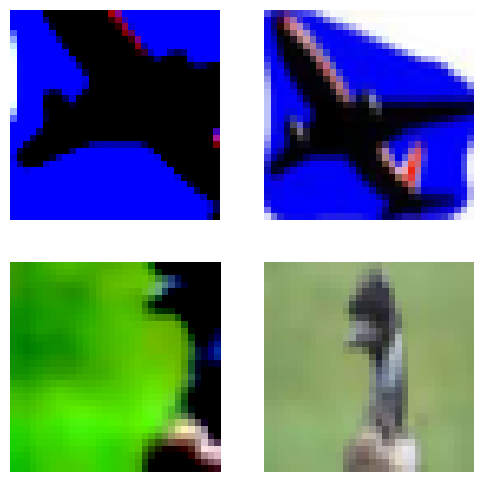

In [ ]:
#| hide
aug_pipelines_supervised = [get_linear_batch_augs(size=size,resize=True,stats=cifar_stats,resize_scale=(0.3, 1.0))]
show_linear_batch(dls=dls_train,n_in=n_in,n=2,aug=aug_pipelines_supervised,print_augs=True)

Helper functions to compute e.g. test set accuracy of a given model. We use test time augmentation

In [ ]:
#| export

@torch.no_grad()
def predict_model(xval,yval,model,aug_pipelines_test,numavg=3,criterion = CrossEntropyLossFlat(),deterministic=False):
    "Note that this assumes xval is entire validation set. If it doesn't fit in memory, can't use this guy"
    
    model.eval()

    N=xval.shape[0]
    
    if not deterministic:

        probs=0
        for _ in range(numavg):

            probs += torch.softmax(model(aug_pipelines_test[0](xval)),dim=1) #test time augmentation. This also gets around issue of randomness in the dataloader in each session...

        probs *= 1/numavg
        
    else:
        probs = torch.softmax(model(xval),dim=1)

    
    ypred = cast(torch.argmax(probs, dim=1),TensorCategory)

    correct = (ypred == yval)#.type(torch.FloatTensor)

    #correct = (torch.argmax(ypred,dim=1) == yval).type(torch.FloatTensor)
    num_correct = correct.sum()
    accuracy = num_correct/N

    #val_loss = criterion(scores,yval)
    
    return probs,ypred,accuracy.item()#,val_loss.item()

@torch.no_grad()
def predict_whole_model(dls_test, model, aug_pipelines_test, numavg=3, criterion=CrossEntropyLossFlat(), deterministic=False):
    """
    Predicts the labels and probabilities for the entire test set using the specified model and data augmentation
    pipelines. Returns a dictionary containing the labels, probabilities, predicted labels, and accuracy.

    Args:
        dls_test: The test dataloader.
        model: The trained model.
        aug_pipelines_test: The test data augmentation pipelines.
        numavg: The number of times to perform test-time augmentation.
        criterion: The loss function to use for computing the accuracy.
        deterministic: Whether to use deterministic computation.

    Returns:
        A dictionary containing the labels, probabilities, predicted labels, and accuracy.
    """
    model.eval()
    total_len = len(dls_test.dataset)
    y = torch.zeros(total_len, dtype=torch.long)
    probs = torch.zeros(total_len, model.head.out_features)
    ypred = torch.zeros(total_len, dtype=torch.long)

    start_idx = 0
    for xval, yval in dls_test.train:
        end_idx = start_idx + len(xval)
        _probs, _ypred, acc = predict_model(xval, yval, model, aug_pipelines_test, numavg, criterion, deterministic)
        y[start_idx:end_idx] = yval
        probs[start_idx:end_idx] = _probs
        ypred[start_idx:end_idx] = _ypred
        start_idx = end_idx

    # Calculate the overall accuracy
    acc = (ypred == y).float().mean().item()

    # Return the predictions and labels in a dictionary
    #return {'y': y, 'probs': probs, 'ypred': ypred, 'acc': acc}
    return y,probs,ypred,acc


This enables us to freeze the encoder as needed:

In [ ]:
#| export
def encoder_head_splitter(m):
    return L(sequential(*m.encoder),m.head).map(params)

`SupervisedLearning` allows us to perform either linear evaluation or semi-supervised learning.

In [ ]:
#| export

class SupervisedLearning:
    "Train model using supervised learning. Either linear evaluation or semi-supervised."

    def __init__(self,encoder,hp_dict):


        self.encoder = encoder
        
        for key, value in hp_dict.items():
            setattr(self, key, value)
        
        self.learn = self.setup_learn()

    
    def setup_learn(self):
        """
        Sets up the learner with the model, callbacks, and metrics.

        Returns:
        - learn: The Learner object.
        """
        # Setup the model: encoder + head
        model = LM(encoder=self.encoder, enc_dim=self.enc_dim, numout=len(self.dls_train.vocab))

        # Setup the learner with callbacks and metrics
        bt = LinearBt(aug_pipelines=self.aug_pipelines_supervised, show_batch=True, n_in=self.n_in, print_augs=True)
        learn = Learner(self.dls_train, model, splitter=encoder_head_splitter,cbs=[bt],wd=0, metrics=accuracy)

        return learn
    
    def supervised_learning(self,epochs:int=1):

        test_grad_on(self.learn.model.encoder)
        test_grad_on(self.learn.model.head)
        lrs = self.learn.lr_find()
        self.learn.fit_one_cycle(epochs, lrs.valley)
        return self.learn.model
    
    def linear_evaluation(self,epochs:int=1):

        self.learn.freeze() #freeze encoder
        test_grad_off(self.learn.model.encoder)
        lrs = self.learn.lr_find() #find learning rate
        self.learn.fit_one_cycle(epochs, lrs.valley) #fit head
        return self.learn.model

    def semi_supervised(self,freeze_epochs:int=1,epochs:int=1):

        self.learn.freeze() #freeze encoder
        test_grad_off(self.learn.model.encoder)
        self.learn.fit(freeze_epochs) #fit head for (typically one) epoch
        self.learn.unfreeze() #unfreeze encoder
        test_grad_on(self.learn.model.encoder)
        test_grad_on(self.learn.model.head)
        lrs = self.learn.lr_find() #find learning rate
        self.learn.fit_one_cycle(epochs, lrs.valley) #fit all
        return self.learn.model


In [ ]:
#debugging

# encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in) #Need an encoder (this will be trained by BT)
# enc_dim = 1024

# model = LM(encoder=encoder, enc_dim=enc_dim, numout=len(dls_train.vocab))

# bt = LinearBt(aug_pipelines=aug_pipelines_supervised, show_batch=True, n_in=n_in, print_augs=True)
# learn = Learner(dls_train, model, splitter=encoder_head_splitter,cbs=[bt],wd=0, metrics=accuracy)

# learn.freeze()
# learn.summary()
# test_grad_off(learn.model.encoder)

Full example of how to use:

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: 


epoch,train_loss,valid_loss,accuracy,time
0,1.915298,None,None,00:00


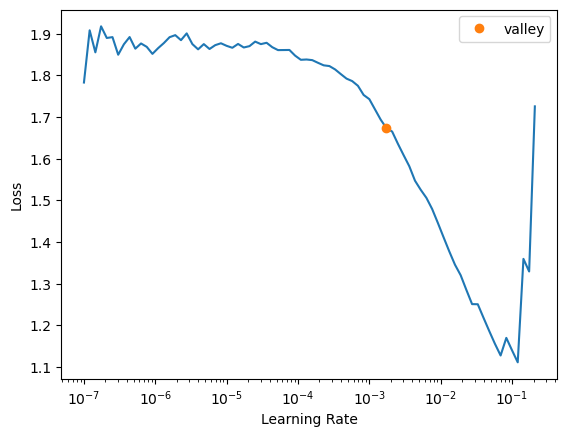

In [ ]:
#| hide

# encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in) #Need an encoder (this will be trained by BT)
# enc_dim=1024

# hp_dict = {'dls_train':dls_train,'dls_test':dls_test, 'aug_pipelines_supervised':aug_pipelines_supervised,'n_in':n_in, 'enc_dim':enc_dim}


# supervised = SupervisedLearning(encoder=encoder,hp_dict=hp_dict)
# model = supervised.linear_evaluation(epochs=1)
# y,probs,ypred,acc = predict_whole_model(dls_test, model, aug_pipelines_supervised, numavg=3, criterion=CrossEntropyLossFlat(), deterministic=False)

# supervised = SupervisedLearning(encoder=encoder,hp_dict=hp_dict)
# model = supervised.semi_supervised(freeze_epochs=2,epochs=2)


One we have a trained model, making predictions and measuring performance on test set is straightforward:


In [ ]:
#| hide

#y,probs,ypred,acc = predict_whole_model(dls_test, model, aug_pipelines_supervised, numavg=3, criterion=CrossEntropyLossFlat(), deterministic=False)
#print(f"Accuracy: {acc:.2f}")

Accuracy: 0.50


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()